# Configuration<a class="anchor" id="CONFIG"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%autosave 5

# necessary modules -------------------------------------------------------------------------------------
import sys
import os
sys.path.append('/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/modules/')
import pyfesom2 as pf
sys.path.append('/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/modules/SkillMetrics/')
import skill_metrics as sm
sys.path.append('/home/ollie/loziel/pyfesom2/codes/py_f2recom_develop/modules/cmocean-master/')
import cmocean as cmo

sys.path.append('../GlobalAssessment/')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
import numpy.ma as ma

Autosaving every 5 seconds


In [2]:
#    Only modify parameters and paths in this cell       #
#  In principle, you don't have to modify anything else  #

# run specification -------------------------------------------------------------------------------------   
runid      =  'fesom'

##############################################################

resultpath = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_CTL/'
simu_name = 'CTL'
savepath = '/home/ollie/chinrich/FIGURES_Alk_experiment_CTL/'

# resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_calc_prod_0_01/'
# savepath = '/home/ollie/chinrich/FIGURES_Alk_experiment_calc_prod_01/'
# simu_name2 = 'calc_prod_01'

# resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_calc_prod_0_03/'
# savepath = '/home/ollie/chinrich/FIGURES_Alk_experiment_calc_prod_03/'
# simu_name2 = 'calc_prod_03'

# resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_red_calc_diss_rate_20/'
# savepath = '/home/ollie/chinrich/FIGURES_Alk_experiment_diss_rate_20/'
# simu_name2 = 'calc_diss_rate_minus20%'

# resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_red_calc_diss_rate_50/'
# savepath = '/home/ollie/chinrich/FIGURES_Alk_experiment_diss_rate_50/'
# simu_name2 = 'fesom2.1-recom_alk-restore-off_calc_diss_rate_50'

# resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_gut_diss/'
# savepath = '/home/ollie/chinrich/FIGURES_Alk_experiment_gut_diss/'
# simu_name2 = 'gut_diss_0.5'


# resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_var_sinkvel/'
# savepath = '/home/ollie/chinrich/FIGURES_Alk_experiment_var_sinkvel/'
# simu_name2 = 'var_sinkvel'

# # period of analysis ------------------------------------------------------------------------------------
first_year_maps = 2020  #2020

first_year = 1960
last_year  = 2020 #2020

runname = simu_name

meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'
    
years = np.arange(first_year,last_year+1,1)
years_last10 = np.arange(first_year_maps,last_year+1,1)

# specification of analysis ------------------------------------------------------------------------------------
layerwise = False
depths = (0,50,200,1000,2000) # If layerwise is True, you can define depths here, by defaut: (0,50,200,1000,2000,4000)
depth_limit = 50
mapproj = 'pc'
#Map projection. Options are Mercator (merc), Plate Carree (pc),
#North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
#Robinson projection is quite time consuming.

# export of analysis ------------------------------------------------------------------------------------
savefig = False
verbose = False

today = date.today().strftime("_%Y_%m_%d")
htmlname     =  simu_name+'_'+ today +'.html'
htmlpath = savepath

if not os.path.exists(htmlpath): # create folders if do not exist
    os.makedirs(htmlpath)
if not os.path.exists(savepath):
    os.makedirs(savepath)

In [3]:
# initialization file specifications -----------------------------------------------------------

evalpath      = '/work/ollie/projects/MarESys/evaluation/'
evalpath2      = '/work/ollie/ogurses/input/corrected_input/'

ncfileAlk                = evalpath2+'GLODAPv2.2016b.TAlk_mmol.nc'
ncfileDIC                = evalpath2+'GLODAPv2.2016b.TCO2_mmol.nc'
ncfileDSi                = evalpath2+'woa13_all_i00_01_fesom2.nc'
ncfileDIN                = evalpath2+'woa13_all_n00_01_fesom2.nc'
ncfileDO2                = evalpath2+'woa18_all_o00_01_mmol_fesom2.nc'
ncfileDFe                = evalpath2+'fe_pisces_opa_eq_init_3D_changed_name.nc' 
ncfileNPPTotalGlobal     = evalpath+'fesom.initial.mesh.diag.nc'
ncfileCO2fluxTotalGlobal = evalpath+'fesom.initial.mesh.diag.nc'
ncfileTemp               = evalpath2+'woa18_decav_t00_01_fesom2.nc'
ncfileSal                = evalpath2+'woa18_decav_s00_01_fesom2.nc'
ncfilePHC3               = evalpath2+'phc3.0_annual.nc'      
ncfilepCO2               = evalpath+'SOCATv6_tracks_gridded_monthly.nc'
ncfileMLD                = evalpath+'mld_DR003.nc'
matfileChlsurf           = evalpath+'climatology_annual_chl_1deg_OCCCI_2012_2015.mat'
txtfileCO2flux           = evalpath+'CO2_flux2015_Takahashietal2009_original.txt'
ncfileMaredat            = evalpath+'MarEDat20120716Diatoms.nc'
ncfileJohnson2013        = evalpath+'Johnson2013_MEAN_1x1_Chl_mg_m3.npy'
matfileNPPvgpn           = evalpath+'VGPN_CLIM.mat'
matfileNPPcpbm           = evalpath+'CBPM_CLIM.mat'
matfileMLD               = evalpath+'GlobalML_Climato_1970_2018.mat'


print('Processing years {4} to {5}\n\nReading out of {0}\nStoring graphs to {1}\nStoring html to {2} as {3}'.format(
    resultpath, savepath, htmlpath, htmlname,years[0],years[-1]))

# just to check
if(verbose):
    print('\nLast ten years are \n{0}'.format(years_last10))
    
# mesh initialization -----------------------------------------------------------
mesh = pf.load_mesh(meshpath)

if False: # check mesh setup nodal and area
    print(mesh)
    print('with depth levels:')
    print(mesh.zlev)
    
    print('\n\nFESOM mesh.diag:')
    meshdiag=resultpath+'/'+runid+'.mesh.diag.nc'
    #!ncdump -h $meshdiag

    diag = pf.get_meshdiag(mesh,meshdiag=meshdiag, runid=runid)
    print(diag)
    print('depth of layers:')
    mesh_depths = diag['nz1'].values
    #print(mesh_depths)
    
    nod_area = diag.nod_area
    nod_area.load()
    #print(np.shape(nod_area[:,:]), type(nod_area)) 

if(verbose):
    print(mesh_depths)
    print(diag)

Processing years 1960 to 2020

Reading out of /work/ollie/chinrich/fesom2_recom/run_alk_restore_off_CTL/
Storing graphs to /home/ollie/chinrich/FIGURES_Alk_experiment_CTL/
Storing html to /home/ollie/chinrich/FIGURES_Alk_experiment_CTL/ as CTL__2022_06_10.html
/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz/pickle_mesh_py3_fesom2


# End configuration

### Alk bias profile

In [4]:
!jupyter nbconvert --to=python Alk_bias_profile.ipynb

from Alk_bias_profile import Alk_bias_profile

[NbConvertApp] Converting notebook Alk_bias_profile.ipynb to python
[NbConvertApp] Writing 2378 bytes to Alk_bias_profile.py
[NbConvertApp] Converting notebook Alk_bias_profile.ipynb to python
[NbConvertApp] Writing 2378 bytes to Alk_bias_profile.py


In [5]:
Bias_CTL = Alk_bias_profile(runid,resultpath,savepath,mesh,ncfileAlk,ncfileDIC,first_year_maps,last_year,
                 savefig=False, regional=False)

***
Loading GLODAP file: /work/ollie/ogurses/input/corrected_input/GLODAPv2.2016b.TAlk_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***


In [6]:
resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_calc_prod_0_01/'
Bias1 = Alk_bias_profile(runid,resultpath2,savepath,mesh,ncfileAlk,ncfileDIC,first_year_maps,last_year,
                 savefig=False, regional=False)

***
Loading GLODAP file: /work/ollie/ogurses/input/corrected_input/GLODAPv2.2016b.TAlk_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***


In [7]:
resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_calc_prod_0_03/'
Bias2 = Alk_bias_profile(runid,resultpath2,savepath,mesh,ncfileAlk,ncfileDIC,first_year_maps,last_year,
                 savefig=False, regional=False)

***
Loading GLODAP file: /work/ollie/ogurses/input/corrected_input/GLODAPv2.2016b.TAlk_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***


In [15]:
resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_gut_diss/'
Bias4 = Alk_bias_profile(runid,resultpath2,savepath,mesh,ncfileAlk,ncfileDIC,first_year_maps,last_year,
                 savefig=False, regional=False)

***
Loading GLODAP file: /work/ollie/ogurses/input/corrected_input/GLODAPv2.2016b.TAlk_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***


In [16]:
resultpath2 = '/work/ollie/chinrich/fesom2_recom/run_alk_restore_off_var_sinkvel/'
Bias5 = Alk_bias_profile(runid,resultpath2,savepath,mesh,ncfileAlk,ncfileDIC,first_year_maps,last_year,
                 savefig=False, regional=False)

***
Loading GLODAP file: /work/ollie/ogurses/input/corrected_input/GLODAPv2.2016b.TAlk_mmol.nc
***
***
Depth greater in FESOM (-6125.0) than in GLODAP (-5500.0)
Please consider choosing max depth level 43 with max depth at -5275.0!
***


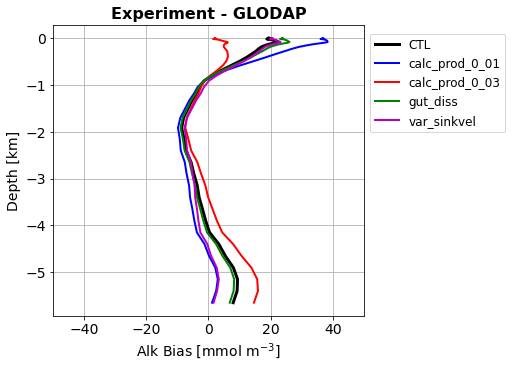

In [19]:
fig, axs = plt.subplots(figsize=(7, 5), facecolor='w', edgecolor='k', constrained_layout=True, sharey=True)

unitsAlk = 'Alk Bias [mmol m$^{-3}$]'
          
axs.plot(Bias_CTL.Bias_out, mesh.zlev[:-1]/1000,label = 'CTL', color = 'k', lw=3)
axs.plot(Bias1.Bias_out, mesh.zlev[:-1]/1000,label = 'calc_prod_0_01', color = 'b', lw=2)
axs.plot(Bias2.Bias_out, mesh.zlev[:-1]/1000,label = 'calc_prod_0_03', color = 'r', lw=2)
axs.plot(Bias4.Bias_out, mesh.zlev[:-1]/1000,label = 'gut_diss', color = 'g', lw=2)
axs.plot(Bias5.Bias_out, mesh.zlev[:-1]/1000,label = 'var_sinkvel', color = 'm', lw=2)


axs.set_ylabel('Depth [km]',fontsize=14)
axs.set_xlim([-50,50])
axs.set_xlabel(unitsAlk,fontsize=14)
axs.set_title('Experiment - GLODAP',size=16, weight='bold')
# axs.set_title(simu_name2 + '\nafter '+ str(last_year-first_year+1) + ' years',size=16, weight='bold')
axs.tick_params(labelsize=14)
axs.grid()
axs.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12)
# axs.legend(loc='lower left', borderaxespad=0.1, fontsize=12)